# Разработка системы анализа и кластеризации отзывов пользователей

## Установка необходимых библиотек

In [ ]:
!pip install scikit-learn matplotlib seaborn numpy pandas nltk spacy pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.4 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=251092ef7e0516f38c9fa237d086d99496c6770bdc2e75a94799d5ce8a210e82
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 845.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Загрузка и предобработка текстовых данных

In [ ]:
# import gdown
# import pandas as pd
# import re
# import nltk
# import spacy
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer
# from tqdm import tqdm
# tqdm.pandas()

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=40)

# # Идентификатор файла в Google Drive
# file_id = '1X1ucpmZC52HHj1Rr4tSie_9q6XrWMWmt'
# url = f'https://drive.google.com/uc?id={file_id}'
# output = 'Test_data_marked.xlsx'
# # Загрузка файла
# gdown.download(url, output, quiet=False)
# data = pd.read_excel(output)

# # Инициализация русского языка в spacy
# nlp = spacy.load('ru_core_news_sm')

# # Формирование списка уникальных стоп-слов для русского языка
# nltk.download('stopwords')
# stop_words = set(stopwords.words('russian'))

# # Итоговая функция для препроцессинга текста
# def preprocess_text(text):
#     # Приведение текста к нижнему регистру
#     text = text.lower()
#     # Удаление спецсимволов и цифр
#     text = re.sub(r'\W', ' ', text)
#     text = re.sub(r'\d', ' ', text)
#     text = re.sub(r'\s+', ' ', text)
#     # Удаление стоп-слов и лемматизация
#     doc = nlp(text)
#     tokens = [token.lemma_ for token in doc if token.text not in stop_words]
#     return ' '.join(tokens)

# data['cleaned_review_text'] = data['review_text'].progress_apply(preprocess_text)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Downloading...
From: https://drive.google.com/uc?id=1X1ucpmZC52HHj1Rr4tSie_9q6XrWMWmt
To: /content/Test_data_marked.xlsx
100%|██████████| 2.81M/2.81M [00:00<00:00, 60.6MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 6876/6876 [07:37<00:00, 15.02it/s]


In [ ]:
# data.to_csv("data.csv", index=False)

In [ ]:
# Чтобы каждый раз не делать препроцессинг с нуля, выгружаем уже готовый файл
file_id = '1DSMA6kB6AtAVSs7lvBO4XVbp7V8q1G2h'
url = f'https://drive.google.com/uc?id={file_id}'
preproc_data_path = 'data.csv'
# Загрузка файла
gdown.download(url, preproc_data_path, quiet=False)
data = pd.read_csv(preproc_data_path)

Downloading...
From: https://drive.google.com/uc?id=1DSMA6kB6AtAVSs7lvBO4XVbp7V8q1G2h
To: /content/Test_data_marked.xlsx
100%|██████████| 13.7M/13.7M [00:00<00:00, 147MB/s]


## Подбор модели для извелчения признаков из текстов и модели для последующей кластеризации

### TFIDF

Данных в выборке не очень много (6876), поэтому большой размер эмбеддинга текстов отзывов выбирать нельзя. Организуем перебор гиперпараметров модели по сетке, задав разумные границы значений.

Изначальная попытка варьировать лишь параметры Tfidf не увенчалась успехом, поэтому параллельно перебём ещё и несколько значений для количества кластеров

In [ ]:
# Пример подбора гиперпараметров для Tfidf + иерархическая кластеризация

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid



# Задание параметров для подбора
param_grid = {
    'max_features': [40, 50, 80, 100, 300, 500, 750],  # Диапазон значений для max_features
    'ngram_range': [(1, 1), (1, 2)],  # Диапазоны n-grams
    'max_df': [0.5, 0.6, 0.7, 0.8, 1.0],
    'min_df': [0.1, 0.2, 0.3, 0.4, 1],
    'n_clusters': [3, 5, 7, 9, 12],  # Количество кластеров для агломеративного метода
    'linkage': ['ward', 'complete', 'average', 'single']  # Методы связи
}

# Подбор параметров
best_score = -1
best_params = None
best_model = None
best_vectorizer = None
params_list = []
scores_list = []

for params in ParameterGrid(param_grid):
    tfidf_vectorizer = TfidfVectorizer(max_features=params['max_features'],
                                       ngram_range=params['ngram_range'],
                                       max_df=params['max_df'],
                                       min_df=params['min_df'])
    X = tfidf_vectorizer.fit_transform(data['cleaned_review_text']).toarray()

    if X.shape[1] < 25:
        continue

    # Использование агломеративной кластеризации
    agglomerative = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage=params['linkage']).fit(X)
    labels = agglomerative.labels_

    # Оценка качества кластеризации
    silhouette_avg = silhouette_score(X, labels)

    params_list.append(params)
    scores_list.append(silhouette_avg)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params
        best_model = agglomerative
        best_vectorizer = tfidf_vectorizer
        print(f"Лучшие параметры: {best_params}, \n Лучший скор: {best_score}\n\n")

print(f"Лучшие параметры для агломеративной кластеризации: {best_params}")
print(f"Лучший силуэтный коэффициент: {best_score}")

In [ ]:
  # Пример подбора гиперпараметров для Tfidf + K_means

from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans

param_grid = {
    'max_features': [40, 50, 80, 100, 300, 500, 750],  # Диапазон значений для max_features
    'ngram_range': [(1, 1), (1, 2)],  # Диапазоны n-grams
    'max_df': [0.5, 0.6, 0.7, 0.8, 1.0],
    'min_df': [0.1, 0.2, 0.3, 0.4, 1],
    'optimal_clusters': [3, 5, 7, 9, 12]
}

# Подбор параметров
best_score = -1
best_params = None
best_model = None
best_vectorizer = None
params_list = []
scores_list = []

for params in ParameterGrid(param_grid):
    tfidf_vectorizer = TfidfVectorizer(max_features=params['max_features'],
                                       ngram_range=params['ngram_range'],
                                       max_df=params['max_df'],
                                       min_df=params['min_df'])
    X = tfidf_vectorizer.fit_transform(data['cleaned_review_text'])

    if X.shape[1] < 25:
      continue

    # Использование KMeans для кластеризации
    optimal_clusters = params['optimal_clusters']
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0, n_init='auto').fit(X)
    labels = kmeans.labels_

    # Оценка качества кластеризации
    silhouette_avg = silhouette_score(X, labels)

    params_list.append(params)
    scores_list.append(silhouette_avg)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params
        best_model = kmeans
        best_vectorizer = tfidf_vectorizer
        print(f"Лучшие параметры: {best_params}, \n Лучший скор: {best_score}\n\n")

In [ ]:
# Пример подбора гиперпараметров для Tfidf + DBScan
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid


# Задание параметров для подбора
param_grid = {
    'max_features': [40, 50, 80, 100, 300, 500, 750],  # Диапазон значений для max_features
    'ngram_range': [(1, 1), (1, 2)],  # Диапазоны n-grams
    'max_df': [0.5, 0.6, 0.7, 0.8, 1.0],
    'min_df': [0.1, 0.2, 0.3, 0.4, 1],
    'eps': [0.3, 0.4, 0.5, 0.6, 0.7],  # Диапазон значений для eps в DBSCAN
    'min_samples': [2, 3, 5, 10]  # Диапазон значений для min_samples в DBSCAN
}

# Подбор параметров
best_score = -1
best_params = None
best_model = None
best_vectorizer = None
params_list = []
scores_list = []

for params in ParameterGrid(param_grid):
    tfidf_vectorizer = TfidfVectorizer(max_features=params['max_features'],
                                       ngram_range=params['ngram_range'],
                                       max_df=params['max_df'],
                                       min_df=params['min_df'])
    try:
      X = tfidf_vectorizer.fit_transform(data['cleaned_review_text']).toarray()
    except:
      continue

    if X.shape[1] < 25:
        continue

    # Использование DBSCAN для кластеризации
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], metric='cosine').fit(X)
    labels = dbscan.labels_

    # Проверка на достаточное количество кластеров
    if len(set(labels)) <= 1:
        continue

    # Оценка качества кластеризации
    silhouette_avg = silhouette_score(X, labels)

    params_list.append(params)
    scores_list.append(silhouette_avg)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params
        best_model = dbscan
        best_vectorizer = tfidf_vectorizer
        print(f"Лучшие параметры: {best_params}, \n Лучший скор: {best_score}\n\n")

print(f"Лучшие параметры для DBSCAN: {best_params}")
print(f"Лучший силуэтный коэффициент: {best_score}")

К сожалению, ни один из вариантов не дал достаточного качества кластеризации по метрике "силуэт". Из плюсов: данная модель хорошо интерпретируется и быстро обучается.
Проблема недостатка качества могла быть в следующих факторах:
* Tfidf не учитывает порядок слов
* Tfidf никак не учитывает синонимы
* Tfidf никак не учитывает контекст слов

### BERT

Заведомо имеет следующие достоинства (хоть и требует достаточных ресурсов по памяти и времени):
* Контекстуальные двунаправленные эмбеддинги
* Учитывает контекст слов и их взаимосвязь в предложении
* Показывает лучшие результаты без препроцессинга



In [ ]:
import gdown
import pandas as pd

# Идентификатор файла в Google Drive
file_id = '1X1ucpmZC52HHj1Rr4tSie_9q6XrWMWmt'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'Test_data_marked.xlsx'
# Загрузка файла
gdown.download(url, output, quiet=False)
data = pd.read_excel(output)

Downloading...
From: https://drive.google.com/uc?id=1X1ucpmZC52HHj1Rr4tSie_9q6XrWMWmt
To: /content/Test_data_marked.xlsx
100%|██████████| 2.81M/2.81M [00:00<00:00, 201MB/s]


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Загрузка предобученного токенайзера и самой модели BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Функция для получения эмбеддинга текста
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
def get_text_embedding(text_list):
    embeddings = []
    # Используем tqdm для отслеживания прогресса
    for text in tqdm(text_list, desc="Вычисление эмбеддингов", leave=False):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(embedding)
    return embeddings

In [ ]:
# Вычисляем эмбеддинги для всех отзывов
from tqdm import tqdm
tqdm.pandas()

X = get_text_embedding(data['review_text'].to_list())

In [ ]:
# Сохраняем в файл (на всякий случай)

np.savetxt('embeddings.txt', X, delimiter=',')

from google.colab import files
files.download('embeddings.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # Загружаем заранее посчитанные bert-эмбеддинги для всех отзывов
# X_loaded = np.loadtxt('embeddings.txt', delimiter=',')

## Кластеризация:
* вычисление метрики "силуэт" для каждого значения гиперпараметра k
* отбор оптимального значения в месте пика графика

P.S. Обоснование превосходства метрики "силуэт" перед выбором количества кластеров методом "локтя" описана в статье по ссылке https://habr.com/ru/companies/jetinfosystems/articles/467745/

In [ ]:
# Попытки снизить размерность эмбеддинга BERT
# Спойлер: качество кластеризации не повысилось

from sklearn.decomposition import PCA

X_loaded = np.loadtxt('embeddings.txt', delimiter=',')
X = np.array(X_loaded)

# Здесь можно перебирать разные размерности
pca = PCA(n_components=80)

# Применяем PCA к данным
X = pca.fit_transform(X)

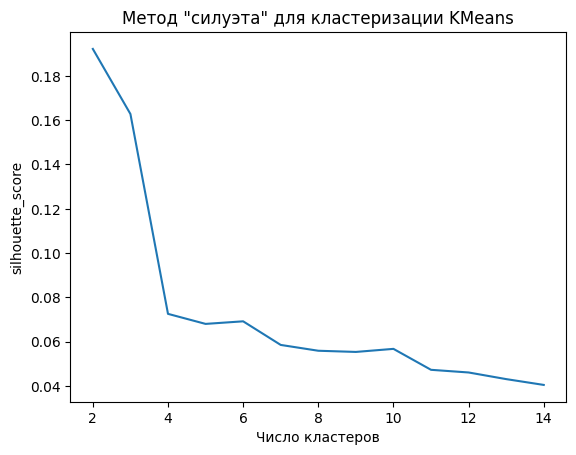

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Определение оптимального количества кластеров методом "силуэта"
sil = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    sil.append(silhouette_score(X, kmeans.fit_predict(X)))

plt.plot(range(2, 15), sil)
plt.title('Метод "силуэта" для кластеризации KMeans')
plt.xlabel('Число кластеров')
plt.ylabel('silhouette_score')
plt.show()

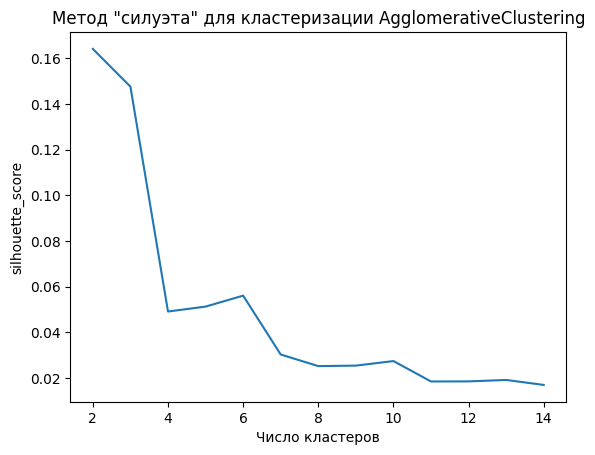

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Определение оптимального количества кластеров методом "силуэта"
sil = []
for i in range(2, 15):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage='ward')
    sil.append(silhouette_score(X, agglomerative.fit_predict(X)))

plt.plot(range(2, 15), sil)
plt.title('Метод "силуэта" для кластеризации AgglomerativeClustering')
plt.xlabel('Число кластеров')
plt.ylabel('silhouette_score')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid

# Вывод на графике количества кластеров и метрики "силуэт"
param_grid = {
    'eps': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],  # Диапазон значений для eps в DBSCAN
    'min_samples': [2, 3, 4, 5, 6]  # Диапазон значений для min_samples в DBSCAN
}
list_sil = []
list_num_clust = []
for params in ParameterGrid(param_grid):
  dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], metric='cosine').fit(X)
  labels = dbscan.labels_
  try:
    list_sil.append(silhouette_score(X, dbscan.fit_predict(X)))
    list_num_clust.append(len(set(labels)))
  except:
    continue

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=2, metric='cosine').fit(X)
labels = dbscan.labels_
print(silhouette_score(X, dbscan.fit_predict(X)))

-0.10077500683442352


In [ ]:
from collections import Counter
Counter(labels)

Counter({-1: 6871, 0: 5})

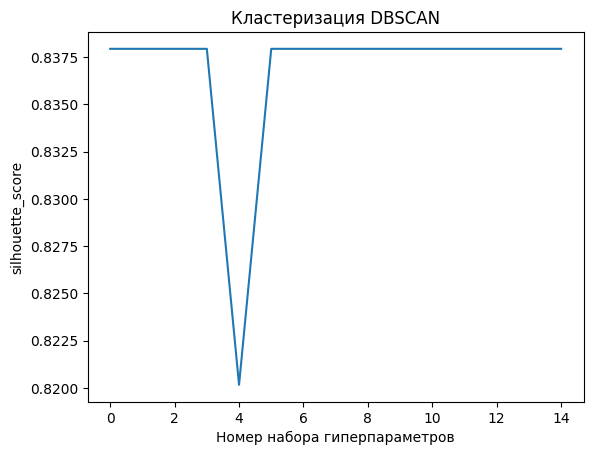

In [ ]:
plt.plot(range(0, len(list_sil)), list_sil)
plt.title('Кластеризация DBSCAN')
plt.xlabel('Номер набора гиперпараметров')
plt.ylabel('silhouette_score')
plt.show()

Качество DBScan кажется хорошим, но, на самом деле, все объекты просто отнеслись к одному кластеру (второй кластер состоит из одного объекта). Что и даёт такое качество. Но нас это не устраивает

### Остановим свой выбор на иерархической кластеризации.
По графику видно, что оптимальное значение гиперпараметра k достается в первом пике, где скорость возрастания метрики замедляется. Увеличивать количество кластеров более нецелесообразно, т.к. по метрике силуэт оно даёт лишь ухудшение качества кластеризации.

## Кластеризация с оптимальным числом кластеров

### Подбор гиперпараметра linkage

In [ ]:
optimal_clusters = 3
for linkage in ['ward', 'complete', 'average', 'single']:
  agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
  data['cluster'] = agglomerative.fit_predict(X)
  print(f"""Linkage: {linkage},\n\n{data['cluster'].value_counts()}\n\n\n\n""")

Linkage: ward,

cluster
0    3920
2    1546
1    1410
Name: count, dtype: int64
Linkage: complete,

cluster
0    6874
1       1
2       1
Name: count, dtype: int64
Linkage: average,

cluster
0    6874
1       1
2       1
Name: count, dtype: int64
Linkage: single,

cluster
0    6874
2       1
1       1
Name: count, dtype: int64


### Остановимся на linkage='ward', т.к. при данном значении гиперпараметра получаются вменяемые объемы кластеров

Параметр linkage в иерархической кластеризации определяет метод, который используется для вычисления расстояния между кластерами.

Метод 'ward' (метод минимального увеличения дисперсии) заключается в минимизации суммы квадратов отклонений внутри всех кластеров, когда два кластера объединяются.

### В качестве оптимального количества кластеров, всё-таки, выберем 2 по причине самого высокого качества по метрике "силуэт"

In [ ]:
optimal_clusters = 2
agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
data['cluster'] = agglomerative.fit_predict(X)

In [ ]:
data['cluster'].value_counts()

cluster
1    4386
0    2490
Name: count, dtype: int64

## Визуализация кластеров:
* снижение размерности
* визуализация

In [ ]:
np.array(X).shape

(6876, 768)

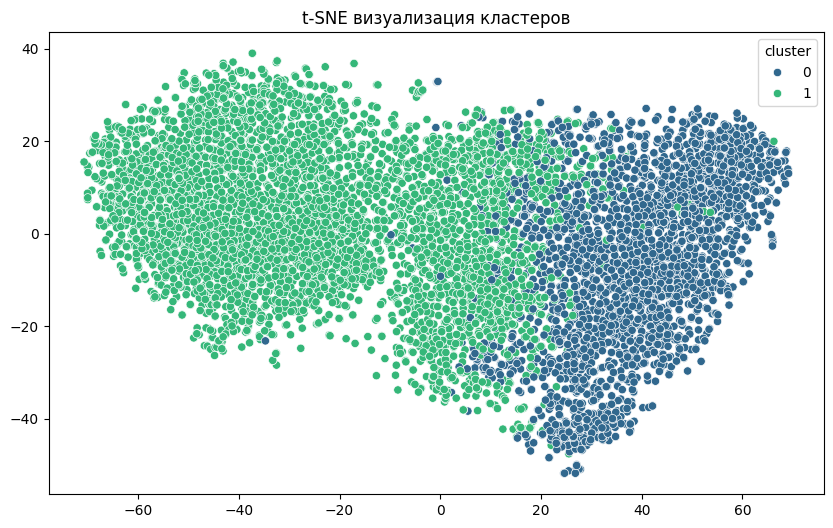

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Снижение размерности для визуализации
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(np.array(X))

# Визуализация кластеров
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data['cluster'], palette='viridis')
plt.title('t-SNE визуализация кластеров')
plt.show()

Качество кластеризации, с визуальной точки зрения, получилось чуть лучше среднего, что можно объяснить следующими причинами:

 **Разнообразие данных**: Возможно, модели сложновато выделить четкие границы между некоторым количеством отзывов об отелях

  **Снижение размерности**: Возможно, при снижении размерности мы потеряли важные признаки и поэтому двумерная визуализация недостаточно точна

 **Выбор признаков**: Количество признаков (размер эмбеддинга BERT = 768) могло повлиять на это. Но ранее перебор (с последовательным снижением размерности методом PCA) показал, что размер эмбеддинга незначительно влияет на качество кластеризации.

**Сложность модели**: Кластеризация может быть сложной задачей, если, на самом деле, кластеров было больше и данные не явно разделяются на такое количество групп. В этом случае кластеры могут быть нечеткими и пересекаться, что приводит к такому качеству кластеризации

**Метрика оценки**: Быть может, выбор метрики "силуэт" дал такой эффект



## Описание кластеров
* Модель TFIDF хорошо подходит для данного исследования
* Важно: тексты должны быть после процессинга

In [ ]:
# Получение словаря терминов из Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=300)

# Чтобы каждый раз не делать препроцессинг с нуля, выгружаем уже готовый файл
file_id = '1DSMA6kB6AtAVSs7lvBO4XVbp7V8q1G2h'
url = f'https://drive.google.com/uc?id={file_id}'
preproc_data_path = 'data.csv'
# Загрузка файла
gdown.download(url, preproc_data_path, quiet=False)
data_preproc = pd.read_csv(preproc_data_path)

X_t = tfidf_vectorizer.fit_transform(data_preproc['cleaned_review_text']).toarray()

terms = tfidf_vectorizer.get_feature_names_out()

# Создание DataFrame для хранения средних значений Tfidf для каждого кластера
tfidf_df = pd.DataFrame(X_t, columns=terms)
tfidf_df['cluster'] = data['cluster']

Downloading...
From: https://drive.google.com/uc?id=1DSMA6kB6AtAVSs7lvBO4XVbp7V8q1G2h
To: /content/data.csv
100%|██████████| 13.7M/13.7M [00:00<00:00, 36.3MB/s]


### Определение ключевых слов для каждого кластера (с повторениями слов)

In [ ]:
# Определение ключевых слов для каждого кластера
# Количество ключевых слов для характеристики каждого кластера
n_terms = 30
key_terms = {}

for cluster in range(optimal_clusters):
    cluster_tfidf = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns='cluster')
    mean_tfidf = cluster_tfidf.mean().sort_values(ascending=False)
    key_terms[cluster] = mean_tfidf.head(n_terms).index.tolist()

# Вывод ключевых слов для каждого кластера
for cluster, terms in key_terms.items():
    print(f'Кластер {cluster}: {", ".join(terms)}')

Кластер 0: отель, очень, номер, хороший, персонал, завтрак, отличный, расположение, удобный, рядом, метро, уютный, центр, понравиться, чистый, прекрасный, цена, приветливый, обслуживание, минута, место, маленький, ресторан, чисто, вкусный, рекомендовать, останавливаться, гостиница, париж, качество
Кластер 1: отель, номер, очень, это, завтрак, хороший, метро, персонал, день, минута, рядом, париж, удобный, расположение, гостиница, этаж, комната, маленький, центр, окно, ресторан, цена, отличный, место, понравиться, вид, кровать, весь, чистый, приятный


### Определение ключевых слов для каждого кластера (без повторений слов)

In [ ]:
# Определение ключевых слов для каждого кластера
n_terms = 30
key_terms = {}

# Получение ключевых слов для каждого кластера
for cluster in range(optimal_clusters):
    cluster_tfidf = tfidf_df[tfidf_df['cluster'] == cluster].drop(columns='cluster')
    mean_tfidf = cluster_tfidf.mean().sort_values(ascending=False)
    key_terms[cluster] = mean_tfidf.head(n_terms).index.tolist()

# Определение уникальных ключевых слов для каждого кластера
unique_key_terms = {}

for cluster in key_terms:
    other_clusters_terms = set([term for other_cluster in key_terms if other_cluster != cluster for term in key_terms[other_cluster]])
    unique_terms = [term for term in key_terms[cluster] if term not in other_clusters_terms]
    unique_key_terms[cluster] = unique_terms[:n_terms]

# Вывод уникальных ключевых слов для каждого кластера
for cluster, terms in unique_key_terms.items():
    print(f'Кластер {cluster}: {", ".join(terms)}')

Кластер 0: уютный, прекрасный, приветливый, обслуживание, чисто, вкусный, рекомендовать, останавливаться, качество
Кластер 1: это, день, этаж, комната, окно, вид, кровать, весь, приятный


### Описание кластеров:

#### Кластер 0:
Кластер 0 включает отзывы, акцентирующие внимание на комфорте и удобствах отеля. Основные темы включают:
- **Комфорт и уют:** гости упоминают, что отель уютный и прекрасно подходит для отдыха.
- **Обслуживание и персонал:** положительные отзывы о приветливом персонале и хорошем обслуживании.
- **Расположение:** отель удобно расположен рядом с метро и в центре города, что делает его идеальным для туристов.
- **Чистота и качество:** гости отмечают чистоту номеров и высокое качество предоставляемых услуг.
- **Завтрак и ресторан:** многие положительно отзываются о завтраках и еде в ресторане отеля.
- **Рекомендации и повторные визиты:** многие гости рекомендуют этот отель и готовы остановиться здесь снова.

Примеры ключевых слов: отель, уютный, персонал, завтрак, отличный, расположение, метро, центр, чистый, вкусный, рекомендовать, гостиница, качество.

#### Кластер 1:
Кластер 1 содержит отзывы, которые больше сосредоточены на общих впечатлениях от пребывания и некоторых конкретных аспектах номеров. Основные темы включают:
- **Общие впечатления:** отзывы часто содержат общие комментарии о хорошем и плохом в отеле.
- **Номера и удобства:** упоминания о номерах, их размерах и удобствах, таких как окна с видом и кровати.
- **Расположение:** как и в кластере 0, гости отмечают удобное расположение рядом с метро и в центре города.
- **Цена и ценность:** отзывы содержат упоминания о цене и соотношении цены и качества.
- **Окружение и вид:** упоминания о виде из окон и окружающей территории.
- **Приятные мелочи:** такие как уютные комнаты и приятные детали интерьера.

Примеры ключевых слов: отель, номер, завтрак, метро, день, рядом, удобный, расположение, комната, окно, вид, кровать, центр, приятный.

### Детализированное описание:

#### Кластер 0:
Отзывы, относящиеся к кластеру 0, характеризуются большим акцентом на комфорте и уюте отеля. Гости часто упоминают, что номера и общественные зоны очень уютные и хорошо подходят для отдыха. Прекрасный персонал и высокое качество обслуживания оставляют приятные впечатления у посетителей. Многие положительно отмечают расположение отеля рядом с метро и в центре города, что делает его удобным для туристов. Чистота номеров и высокое качество предоставляемых услуг также выделяются в отзывах. Завтраки и еда в ресторане отеля получают много положительных отзывов. Многие гости рекомендуют этот отель и планируют остановиться здесь снова.

#### Кластер 1:
Отзывы в кластере 1 более сосредоточены на общих впечатлениях от пребывания. Часто упоминаются различные аспекты номеров, такие как их размер и удобства, окна с видом и кровати. Как и в кластере 0, гости отмечают удобное расположение отеля рядом с метро и в центре города. В отзывах упоминается соотношение цены и качества, что также играет важную роль при выборе отеля. Многие гости отмечают приятные мелочи, такие как уютные комнаты и вид из окон, что дополняет их общее впечатление от пребывания в отеле.

In [ ]:
# Сохранение разметки + текст отзыва
data[['cluster', 'review_text']].to_csv("data_res.csv", index=False)

## Метрики оценки качества кластеризации

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

labels = data['cluster']

silhouette_avg = silhouette_score(X, labels)
print(f"Силуэтный коэффициент: {silhouette_avg:.3f}")

wcss_index = kmeans.inertia_
print(f'Коэффициент WCSS: {wcss_index}')

db_index = davies_bouldin_score(X, labels)
print(f'Коэффициент Дависа-Болдина: {db_index}')

ch_index = calinski_harabasz_score(X, labels)
print(f'Коэффициент Калински-Харабаса: {ch_index}')

Силуэтный коэффициент: 0.198
Коэффициент WCSS: 8486.438759716468
Коэффициент Дависа-Болдина: 2.061500887538999
Коэффициент Калински-Харабаса: 1445.2920038183147


На основании рассчитанных метрик кластеризации можно сделать следующие выводы:

1. **Силуэтный коэффициент (Silhouette Score)**
   - Силуэтный коэффициент варьируется от -1 до 1, где значения ближе к 1 указывают на хорошо отделенные кластеры, значения около 0 означают, что кластеры пересекаются, а отрицательные значения показывают, что точки, возможно, были ошибочно отнесены к кластерам.

2. **Коэффициент WCSS (Within-Cluster Sum of Squares)**
   - WCSS измеряет сумму квадратов расстояний между точками и центроидами их кластеров. Меньшие значения WCSS указывают на более плотные и компактные кластеры.

3. **Коэффициент Дависа-Болдина (Davies-Bouldin Index)**
   - Индекс Дэвиса-Болдина оценивает среднее отношение внутрикластерной дистанции к межкластерной дистанции. Значения варьируются от 0 до бесконечности, и более низкие значения указывают на лучшее качество кластеризации.

4. **Коэффициент Калински-Харабаса (Calinski-Harabasz Index)**
   - Этот индекс измеряет отношение суммы междуклассовой дисперсии к внутриклассовой дисперсии. Более высокие значения указывают на лучшее качество кластеризации.

**Общий вывод**:
Результаты метрик указывают на то, что качество кластеризации чуть выше среднего.

## P.S. Для сравнения метрики альтернативных лучших моделей кластеризации

3 кластера (Bert + AgglomerativeClustering)

* Силуэтный коэффициент: 0.148
* Коэффициент WCSS: 9805.120107891566
* Коэффициент Дависа-Болдина: 2.9256600501151273
* Коэффициент Калински-Харабаса: 812.4585974655664

2 кластера (Bert + AgglomerativeClustering)
* Силуэтный коэффициент: 0.164
* Коэффициент WCSS: 9805.120107891566
* Коэффициент Дависа-Болдина: 2.2528058633859533
* Коэффициент Калински-Харабаса: 1260.6858206839922

4 кластера (TFIDF + KMeans)
* Силуэтный коэффициент: 0.028
* Коэффициент WCSS: 5172.948703535489
* Коэффициент Дависа-Болдина: 5.195330828109466
* Коэффициент Калински-Харабаса: 142.99585431263847

## Разработка модели для автоматической категоризации:
* формирование датасета
* обучение модели
* рассчёт метрик классификации accuracy, precision, recall, f1
* визуализация roc-кривой и precision-recall-кривой
* отчёт классификации в разрезе классов

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, data['cluster'], test_size=0.2, random_state=42)

# Обучение модели
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Предсказание метрок (+ вероятностей)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

Accuracy: 0.9469476744186046
Precision: 0.9470203344029716
Recall: 0.9469476744186046
F1 Score: 0.9469792329361734


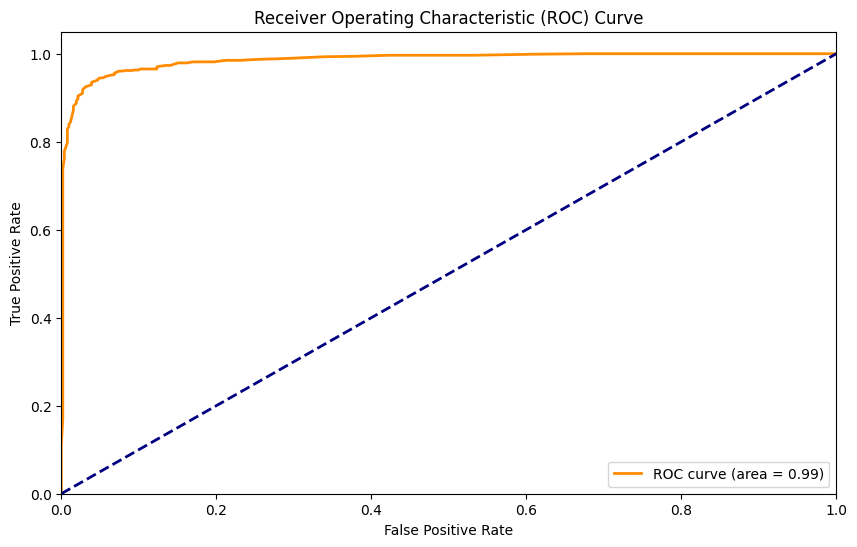

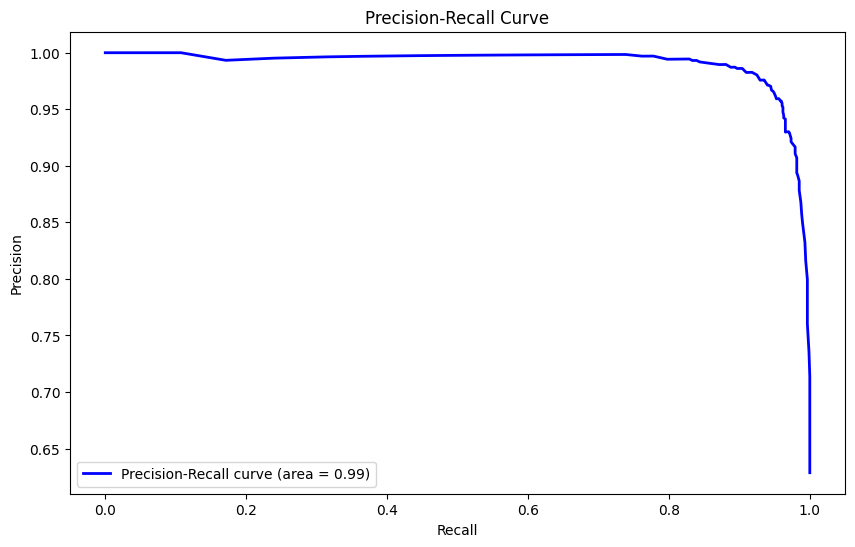

In [ ]:
# Метрики классификации
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

y_prob = clf.predict_proba(X_test)[:, 1]

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       511
           1       0.96      0.96      0.96       865

    accuracy                           0.95      1376
   macro avg       0.94      0.94      0.94      1376
weighted avg       0.95      0.95      0.95      1376



На основании полученных метрик можно сделать следующие выводы об обученной модели автоматической категоризации отзывов:

1. **Точность (Accuracy)**:
   - Модель демонстрирует высокую точность, что означает, что большая часть отзывов была классифицирована правильно. Это указывает на то, что модель в целом хорошо справляется с задачей категоризации отзывов.

2. **Точность (Precision)**:
   - Высокая точность модели означает, что среди отзывов, которые модель определила как принадлежащие к определенной категории, большинство действительно принадлежат к этой категории. Это важно для приложений, где ложные срабатывания могут иметь значительные негативные последствия.

3. **Полнота (Recall)**:
   - Высокий показатель полноты указывает на то, что модель успешно находит большинство отзывов, принадлежащих к каждой категории. Это значит, что модель практически не пропускает релевантные отзывы.

4. **F1-мера (F1 Score)**:
   - Высокая F1-мера, являющаяся гармоническим средним между точностью и полнотой, подтверждает, что модель сбалансирована и эффективно справляется как с минимизацией ложноположительных, так и с минимизацией ложноотрицательных классификаций.

**Общий вывод**:
Модель автоматической категоризации отзывов демонстрирует отличные результаты по всем основным метрикам. Она хорошо справляется с точной и полной категоризацией отзывов, что делает её пригодной для практического применения в задачах, где требуется автоматическая классификация текста отзыва. Тем не менее, всё вышесказанное верно, только если исходная кластеризация выполнена верно, ведь ML-модель лишь предсказывает нашу собственную разметку (из кластеризации).